# BubbleAI ? Digital Twin quickstart

Load the BubbleAI packaged .h5 files, explore images/metadata, and expose them through a minimal microscope-like API you can plug into downstream Digital Twin experiments.


In [1]:

from pathlib import Path
from io import StringIO
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path('../data/BubbleAI/h5').resolve()
print('Data dir:', DATA_DIR)
if not DATA_DIR.exists():
    raise FileNotFoundError('Expected data/BubbleAI/h5 to exist.')


Data dir: C:\Users\aisci\OneDrive\Desktop\DTMicroscope-main\data\BubbleAI\h5


In [2]:

h5_files = sorted(DATA_DIR.glob('*.h5'))
if not h5_files:
    raise RuntimeError('No .h5 files in data/BubbleAI/h5')

# pick the first file that has images; fallback to the first file

def file_has_images(path: Path) -> bool:
    with h5py.File(path, 'r') as h5:
        return 'images' in h5 and int(h5.attrs.get('image_count', 0)) > 0

image_h5 = next((p for p in h5_files if file_has_images(p)), h5_files[0])
print('Default selection:', image_h5.name)


Default selection: 0_25_wt_coco_b_0_75wt_coco_glucoside.h5


In [3]:

def load_bubble_h5(path: Path):
    '''Return image stack, filenames, metadata tables, and attributes.'''
    with h5py.File(path, 'r') as h5:
        images = None
        filenames = []
        if 'images' in h5:
            images = np.array(h5['images/data'])
            filenames = [f.decode('utf-8') if isinstance(f, (bytes, bytearray)) else str(f) for f in h5['images/filenames']]

        metadata = {}
        if 'metadata' in h5:
            for key, ds in h5['metadata'].items():
                raw = ds[()]
                text = raw.decode('utf-8') if isinstance(raw, (bytes, bytearray)) else str(raw)
                metadata[key] = pd.read_csv(StringIO(text))

        attrs = dict(h5.attrs)
    return images, filenames, metadata, attrs

class BubbleAIDTMicroscope:
    '''Lightweight digital-twin-like wrapper around BubbleAI HDF5.'''
    def __init__(self, h5_path: Path):
        self.h5_path = Path(h5_path)
        self.images, self.filenames, self.metadata, self.attrs = load_bubble_h5(self.h5_path)
        self.channel_count = self.images.shape[-1] if self.images is not None else 0
        self.frame_count = 0 if self.images is None else self.images.shape[0]
        self.height = None if self.images is None else self.images.shape[1]
        self.width = None if self.images is None else self.images.shape[2]

    def get_overview_image(self, idx: int = 0):
        if self.images is None or self.frame_count == 0:
            raise RuntimeError('No images stored in this H5 file')
        return self.images[idx]

    def get_point_data(self, idx: int, x: int, y: int):
        frame = self.get_overview_image(idx)
        return frame[y, x]

    def list_metadata_tables(self):
        return list(self.metadata.keys())

    def get_metadata_table(self, key: str) -> pd.DataFrame:
        return self.metadata[key]


In [4]:

mic = BubbleAIDTMicroscope(image_h5)
print('Frames:', mic.frame_count, '| size:', (mic.height, mic.width), '| channels:', mic.channel_count)
print('Metadata tables:', mic.list_metadata_tables())
print('Attributes:', mic.attrs)


Frames: 427 | size: (1080, 1319) | channels: 3
Metadata tables: ['0_25_wt_coco_betain_0_75wt_coco_glucoside_bd']
Attributes: {'image_count': np.int64(427), 'metadata_files': '["0.25 wt%   coco-betain & 0.75wt %coco- glucoside BD.xlsx"]', 'mixture_name': '0.25 wt% coco- B & 0.75wt % coco-Glucoside', 'source_dir': 'C:\\Users\\aisci\\OneDrive\\Desktop\\DTMicroscope-main\\BubbleAI Microscope\\0.25 wt% coco- B & 0.75wt % coco-Glucoside'}


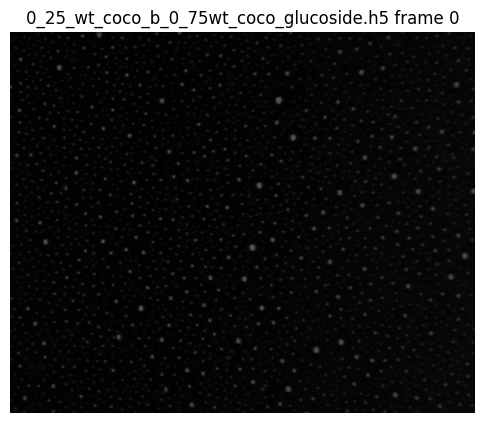

In [5]:

frame_idx = 0
frame = mic.get_overview_image(frame_idx)
plt.figure(figsize=(6,6))
plt.imshow(frame)
plt.title(f'{image_h5.name} frame {frame_idx}')
plt.axis('off')
plt.show()


In [6]:

x, y = mic.width // 2, mic.height // 2
pixel_rgb = mic.get_point_data(idx=frame_idx, x=x, y=y)
print('Pixel RGB at center:', pixel_rgb)


Pixel RGB at center: [3 3 3]


In [7]:

if mic.list_metadata_tables():
    first_key = mic.list_metadata_tables()[0]
    df = mic.get_metadata_table(first_key)
    print('Metadata table:', first_key, '| shape:', df.shape)
    display(df.head())
else:
    print('No metadata tables found in this file.')


Metadata table: 0_25_wt_coco_betain_0_75wt_coco_glucoside_bd | shape: (477, 10)


,t [s],BC [mm⁻²],M̅B̅A̅ [µm²],SD M̅B̅A̅ [µm²],Ravg [µm],Rrms [µm],R21 [µm],R32 [µm],v,w
0,445.57,89.924,11120,5925,58,59,61,65,2,4
1,450.57,86.258,11593,6286,59,61,63,67,2,3
2,455.57,86.049,11621,6813,59,61,63,68,2,5
3,460.57,85.899,11642,6733,59,61,63,68,2,5
4,465.57,86.367,11578,6480,59,61,63,67,2,5


## Notes for Digital Twin integration
- The BubbleAIDTMicroscope class exposes get_overview_image and get_point_data methods similar to the DT microscope API, so you can swap it into downstream notebooks or Pyro servers if needed.
- If you need to serve this over Pyro, instantiate BubbleAIDTMicroscope inside a server wrapper (following DTMicroscope/server/server_stem.py) and route calls to these methods.
- The loader keeps metadata as Pandas DataFrames so you can join experimental conditions with image-derived features.
